In [1]:
#!pip install tensorflow

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
#!pip install yfinance

In [4]:
import yfinance as yf

In [5]:
stock_symbol = 'BTC-USD'

In [6]:
data = yf.download(tickers = stock_symbol,period ='5y',interval ='1d')

[*********************100%***********************]  1 of 1 completed


In [7]:
type(data)

pandas.core.frame.DataFrame

In [8]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-23,13948.700195,15603.200195,13828.799805,14699.200195,14699.200195,13086000128
2017-12-24,14608.200195,14626.000000,12747.700195,13925.799805,13925.799805,11572299776
2017-12-25,13995.900391,14593.000000,13448.900391,14026.599609,14026.599609,10664699904
2017-12-26,14036.599609,16461.199219,14028.900391,16099.799805,16099.799805,13454300160
2017-12-27,16163.500000,16930.900391,15114.299805,15838.500000,15838.500000,12487600128


In [9]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-19,16759.041016,16807.527344,16398.136719,16439.679688,16439.679688,17221074814
2022-12-20,16441.787109,17012.984375,16427.867188,16906.304688,16906.304688,22722096615
2022-12-21,16904.527344,16916.800781,16755.912109,16817.535156,16817.535156,14882945045
2022-12-22,16818.380859,16866.673828,16592.408203,16830.341797,16830.341797,16441573050
2022-12-23,16825.230469,16877.648438,16796.140625,16845.783203,16845.783203,16581948416


In [10]:
opn = data[['Open']]

<AxesSubplot:xlabel='Date'>

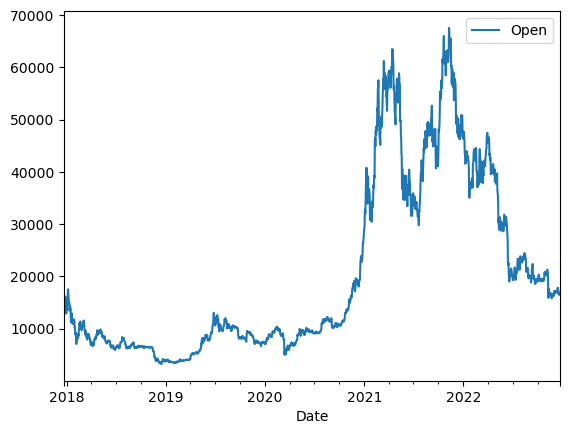

In [11]:
opn.plot()

In [12]:
import matplotlib.pyplot as plt

In [13]:
ds = opn.values

In [14]:
ds

array([[13948.70019531],
       [14608.20019531],
       [13995.90039062],
       ...,
       [16904.52734375],
       [16818.38085938],
       [16825.23046875]])

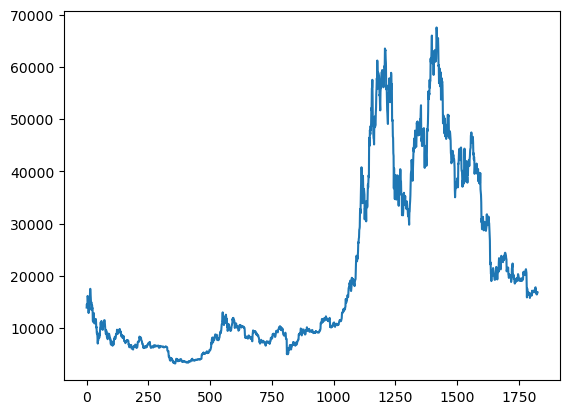

In [15]:
plt.plot(ds);

In [16]:
import numpy as np

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [19]:
len(ds_scaled),len(ds)

(1827, 1827)

In [20]:
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled)-train_size

In [21]:
train_size,test_size

(1278, 549)

In [22]:
ds_train,ds_test = ds_scaled[0:train_size,:],ds_scaled[train_size:len(ds_scaled),:1]

In [23]:
len(ds_train),len(ds_test)

(1278, 549)

In [24]:
#creating dataset in time series for LSTM
def create_ds(dataset,step):
    Xtrain,Ytrain = [],[]
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step),0]
        Xtrain.append(a)
        Ytrain.append(dataset[i+step,0])
    return np.array(Xtrain),np.array(Ytrain)

In [25]:
#taking 100 days price as one record for training
time_stamp = 100
x_train,y_train = create_ds(ds_train,time_stamp)
x_test,y_test = create_ds(ds_test,time_stamp)

In [26]:
x_train.shape,y_train.shape

((1177, 100), (1177,))

In [27]:
x_test.shape,y_test.shape

((448, 100), (448,))

In [28]:
#reshaping data to fit into LSTM model
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test =x_test.reshape(x_test.shape[0],x_test.shape[1],1)


In [29]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [30]:
#creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [31]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer = 'adam')
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
19/19 [==============================] - 9s 196ms/step - loss: 0.0172 - val_loss: 0.0096
Epoch 2/10
19/19 [==============================] - 2s 129ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 3/10
19/19 [==============================] - 2s 128ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 4/10
19/19 [==============================] - 2s 126ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 5/10
19/19 [==============================] - 2s 126ms/step - loss: 0.0012 - val_loss: 0.0059
Epoch 6/10
19/19 [==============================] - 2s 126ms/step - loss: 0.0013 - val_loss: 0.0051
Epoch 7/10
19/19 [==============================] - 2s 125ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 8/10
19/19 [==============================] - 4s 221ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 9/10
19/19 [==============================] - 3s 164ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 10/10
19/19 [==============================] - 2s 131ms/step - loss: 0.0013 - val_loss: 0.0029

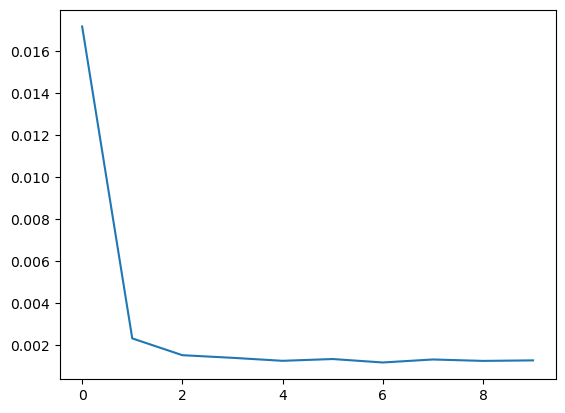

In [32]:
#plotting loss,it showsthat loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [33]:
#Predicting on train and test data
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

14/14 [==============================] - 0s 30ms/step


In [34]:
#inverse transforn to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

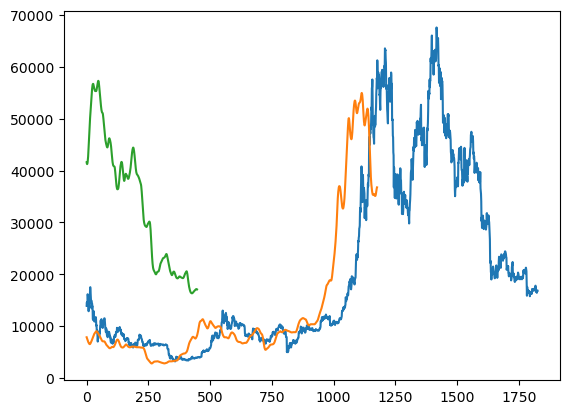

In [35]:
#comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [36]:
type(train_predict)

numpy.ndarray

In [37]:
test = np.vstack((train_predict,test_predict))

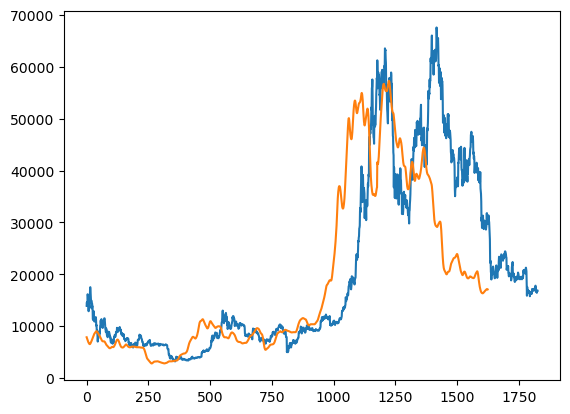

In [38]:
#combining the predicted data to creatye uniforn data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [39]:
len(ds_test)

549

In [40]:
#getting  the last 100 days records
fut_inp = ds_test[270:]

In [41]:
fut_inp = fut_inp.reshape(1,-1)

In [42]:
tmp_inp = list(fut_inp)

In [43]:
#creating list of the last 100 days
tmp_inp = tmp_inp[0].tolist()


In [44]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=(len(ds_test)-271)
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)
        

[[0.2141355276107788], [0.21348118782043457], [0.21294628083705902], [0.2125323861837387], [0.212222620844841], [0.21199345588684082], [0.21182145178318024], [0.21168680489063263], [0.2115744650363922], [0.211473748087883], [0.21137785911560059], [0.21128274500370026], [0.21118631958961487], [0.21108771860599518], [0.2109869122505188], [0.21088409423828125], [0.2107795923948288], [0.21067377924919128], [0.2105669230222702], [0.21045935153961182], [0.21035121381282806], [0.21024252474308014], [0.2101334184408188], [0.2100239396095276], [0.20991398394107819], [0.20980365574359894], [0.20969291031360626], [0.20958171784877777], [0.20947016775608063], [0.20935817062854767]]


In [45]:
len(ds_scaled)


1827

In [46]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

In [47]:

ds_new = ds_scaled.tolist()

In [48]:
len(ds_new)


1827

In [49]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()

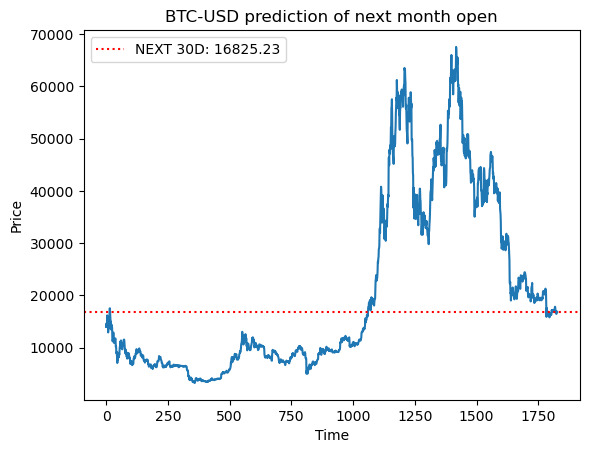

In [50]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

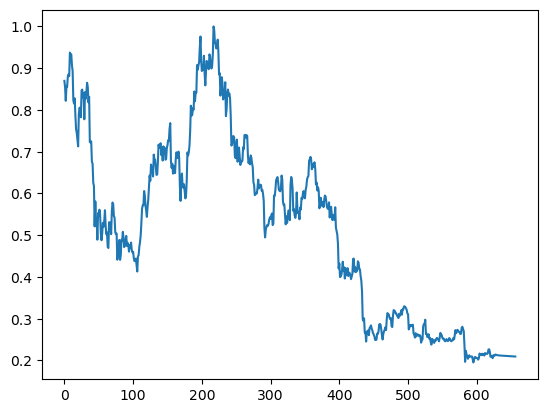

In [51]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

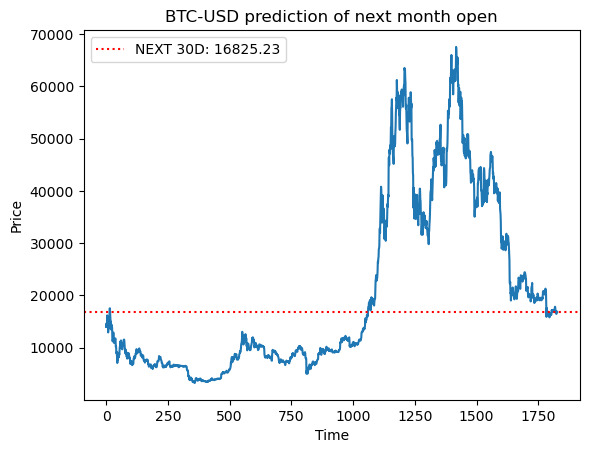

In [52]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()